In [2]:
!pip install pydub soundfile -q
!pip install librosa -q

In [3]:
import librosa
import json
import os
from assets import audio_utlis

In [4]:
SAMPLE_TO_CONSIDER = 22050
DATA_PATH= "data"
JSON_PATH= "command_dataset/audiodataset.json"


In [6]:
#LOADING & PROCESSING AUDIO DATA TO JSON FILE
# audio_utlis.audioData_to_jsonLoaderV2(DATA_PATH,JSON_PATH)

In [7]:
import numpy as np
from sklearn.model_selection import train_test_split


In [48]:
#load the data
PROCCESED_DATA=JSON_PATH
X,y,label_map =audio_utlis.load_thatJsonData(PROCCESED_DATA) 

In [49]:
label_map

[['commandDataSet', 'bed'],
 ['commandDataSet', 'bird'],
 ['commandDataSet', 'cat'],
 ['commandDataSet', 'dog'],
 ['commandDataSet', 'down'],
 ['commandDataSet', 'eight'],
 ['commandDataSet', 'five'],
 ['commandDataSet', 'four'],
 ['commandDataSet', 'go'],
 ['commandDataSet', 'happy'],
 ['commandDataSet', 'house'],
 ['commandDataSet', 'left'],
 ['commandDataSet', 'marvin'],
 ['commandDataSet', 'nine'],
 ['commandDataSet', 'no'],
 ['commandDataSet', 'off'],
 ['commandDataSet', 'on'],
 ['commandDataSet', 'one'],
 ['commandDataSet', 'right'],
 ['commandDataSet', 'seven'],
 ['commandDataSet', 'sheila'],
 ['commandDataSet', 'six'],
 ['commandDataSet', 'snap'],
 ['commandDataSet', 'stop'],
 ['commandDataSet', 'three'],
 ['commandDataSet', 'tree'],
 ['commandDataSet', 'two'],
 ['commandDataSet', 'up'],
 ['commandDataSet', 'wow'],
 ['commandDataSet', 'yes'],
 ['commandDataSet', 'zero']]

In [10]:
#split the data to train and test sets
TEST_SIZE=VALID_SIZE=0.1
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=TEST_SIZE)
X_train,X_validation,y_train,y_validation = train_test_split(X_train,y_train,test_size=VALID_SIZE)

In [11]:
#convert it to 3d numpy array for convotion network
X_train = X_train[...,np.newaxis]
X_test = X_test[...,np.newaxis]
X_validation = X_validation[...,np.newaxis]

In [12]:
# # the acutaul trainning 

import tensorflow.keras as keras

NUM_KEYWRD=len(label_map)
LEARNING_RATE= 1e-4
INPUT_SHAPE=(X_train.shape[1],X_train.shape[2],X_train.shape[3]) #? (segments,13 coff,1 for 3D cov)

In [13]:
#bulid the MOdel
model = keras.Sequential()


# conv layer 1
model.add(keras.layers.Conv2D(32,(3,3),activation="relu",
                            input_shape=INPUT_SHAPE,kernel_regularizer=keras.regularizers.l2(.001)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((3,3),strides=(1,1),padding='same'))



# conv layer 2
model.add(keras.layers.Conv2D(64,(3,3),activation="relu",
                           kernel_regularizer=keras.regularizers.l2(.001)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((3,3),strides=(1,1),padding='same'))
model.add(keras.layers.Dropout(0.2))



# conv layer 3
model.add(keras.layers.Conv2D(64,(3,3),activation="relu",
                           kernel_regularizer=keras.regularizers.l2(.001)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((3,3),strides=(1,1),padding='same'))
model.add(keras.layers.Dropout(0.25))


# conv layer 4
model.add(keras.layers.Conv2D(128,(3,3),activation="relu",
                           kernel_regularizer=keras.regularizers.l2(.001)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2),strides=(1,1),padding='same'))
model.add(keras.layers.Dropout(0.3))


#flatten the 3 dimintion out to 1D dense layer
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256,activation="relu"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.4))


model.add(keras.layers.Dense(128,activation="relu"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.5))

# softmax classifier
model.add(keras.layers.Dense(NUM_KEYWRD,activation="softmax"))

# compile the model
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
lossFUNC=keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer,loss=lossFUNC,metrics=["accuracy"])

#model overview
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 42, 11, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 42, 11, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 42, 11, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 9, 64)         18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 9, 64)         256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 40, 9, 64)         0         
_________________________________________________________________
dropout (Dropout)            (None, 40, 9, 64)         0

In [14]:
# config some hyperParamter for the model
BATCH_SIZE=32
EPOCHS=30

In [15]:
# Load an exsitant model   
# PRETRAIND_MODEL_PATH="trained_models/"#choose the model
# model = keras.models.load_model(MODEL_PATH)
# model.summary()

In [16]:
# #train the model
model.fit(X_train,y_train,epochs=EPOCHS,batch_size=BATCH_SIZE,validation_data=(X_validation,y_validation))
test_error,test_acc=model.evaluate(X_test,y_test)
print(f"test_error: {test_error} ,test_ acc: {test_acc}")
MODEL_PATH=f"genral_MODEL{test_acc:.3f}.h5"
model.save(MODEL_PATH)


Epoch 1/30
1509/1509 [==============================] - 19s 11ms/step - loss: 3.7368 - accuracy: 0.1546 - val_loss: 4.9771 - val_accuracy: 0.2988
Epoch 2/30
1509/1509 [==============================] - 16s 10ms/step - loss: 2.0376 - accuracy: 0.4726 - val_loss: 3.0875 - val_accuracy: 0.5001
Epoch 3/30
1509/1509 [==============================] - 16s 10ms/step - loss: 1.4416 - accuracy: 0.6395 - val_loss: 2.6503 - val_accuracy: 0.5737
Epoch 4/30
1509/1509 [==============================] - 16s 10ms/step - loss: 1.1496 - accuracy: 0.7204 - val_loss: 1.6092 - val_accuracy: 0.7197
Epoch 5/30
1509/1509 [==============================] - 16s 10ms/step - loss: 0.9487 - accuracy: 0.7815 - val_loss: 1.2823 - val_accuracy: 0.7810
Epoch 6/30
1509/1509 [==============================] - 16s 10ms/step - loss: 0.8290 - accuracy: 0.8178 - val_loss: 1.1504 - val_accuracy: 0.8168
Epoch 7/30
1509/1509 [==============================] - 16s 10ms/step - loss: 0.7352 - accuracy: 0.8397 - val_loss: 1.7859 -

In [ ]:
#TUNIING AN EXSISTANT MODEL
# initEPOCHS=29
# EPOCHS=12
# tunned_model = keras.models.load_model(MODEL_PATH)
# tunned_model.compile(optimizer=tunned_model.optimizer,loss=lossFUNC,metrics=["accuracy"])
# tunned_model.fit(X_train,y_train,epochs=20,batch_size=BATCH_SIZE,validation_data=(X_validation,y_validation),verbose=2)


Epoch 1/20
1509/1509 - 11s - loss: 0.2055 - accuracy: 0.9637 - val_loss: 0.3439 - val_accuracy: 0.9407
Epoch 2/20
1509/1509 - 11s - loss: 0.2034 - accuracy: 0.9644 - val_loss: 0.3336 - val_accuracy: 0.9443
Epoch 3/20
1509/1509 - 11s - loss: 0.1997 - accuracy: 0.9642 - val_loss: 0.3442 - val_accuracy: 0.9437
Epoch 4/20
1509/1509 - 11s - loss: 0.1967 - accuracy: 0.9651 - val_loss: 0.3506 - val_accuracy: 0.9394
Epoch 5/20
1509/1509 - 11s - loss: 0.1958 - accuracy: 0.9653 - val_loss: 0.3421 - val_accuracy: 0.9435
Epoch 6/20
1509/1509 - 11s - loss: 0.1855 - accuracy: 0.9685 - val_loss: 0.3447 - val_accuracy: 0.9448
Epoch 7/20
1509/1509 - 11s - loss: 0.1853 - accuracy: 0.9678 - val_loss: 0.3415 - val_accuracy: 0.9409
Epoch 8/20
1509/1509 - 11s - loss: 0.1862 - accuracy: 0.9677 - val_loss: 0.3346 - val_accuracy: 0.9443
Epoch 9/20
1509/1509 - 11s - loss: 0.1781 - accuracy: 0.9697 - val_loss: 0.3486 - val_accuracy: 0.9389
Epoch 10/20
1509/1509 - 11s - loss: 0.1807 - accuracy: 0.9691 - val_loss:

In [18]:
test_error,test_acc= model.evaluate(X_test,y_test)
print(f"test_error: {test_error} ,test_ acc: {test_acc}")

187/187 [==============================] - 1s 4ms/step - loss: 0.3404 - accuracy: 0.9393
test_error: 0.34038203954696655 ,test_ acc: 0.9392719268798828


In [21]:
preds = model.predict(X_test,batch_size=32)
rounded_preds=np.argmax(preds,axis=1)
rounded_preds

array([16, 21, 23, ..., 18,  0, 21])

In [22]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [44]:
cm = confusion_matrix(y_true=y_test, y_pred=rounded_preds)

In [45]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [47]:
label_map = [class_name for class_name in label_map]
label_map

['d',
 'd',
 't',
 'g',
 'n',
 't',
 'e',
 'r',
 'o',
 'y',
 'e',
 't',
 'n',
 'e',
 'o',
 'f',
 'n',
 'e',
 't',
 'n',
 'a',
 'x',
 'p',
 'p',
 'e',
 'e',
 'o',
 'p',
 'w',
 's',
 'o']

In [38]:
cm_plot_labels = label_map

Confusion matrix, without normalization


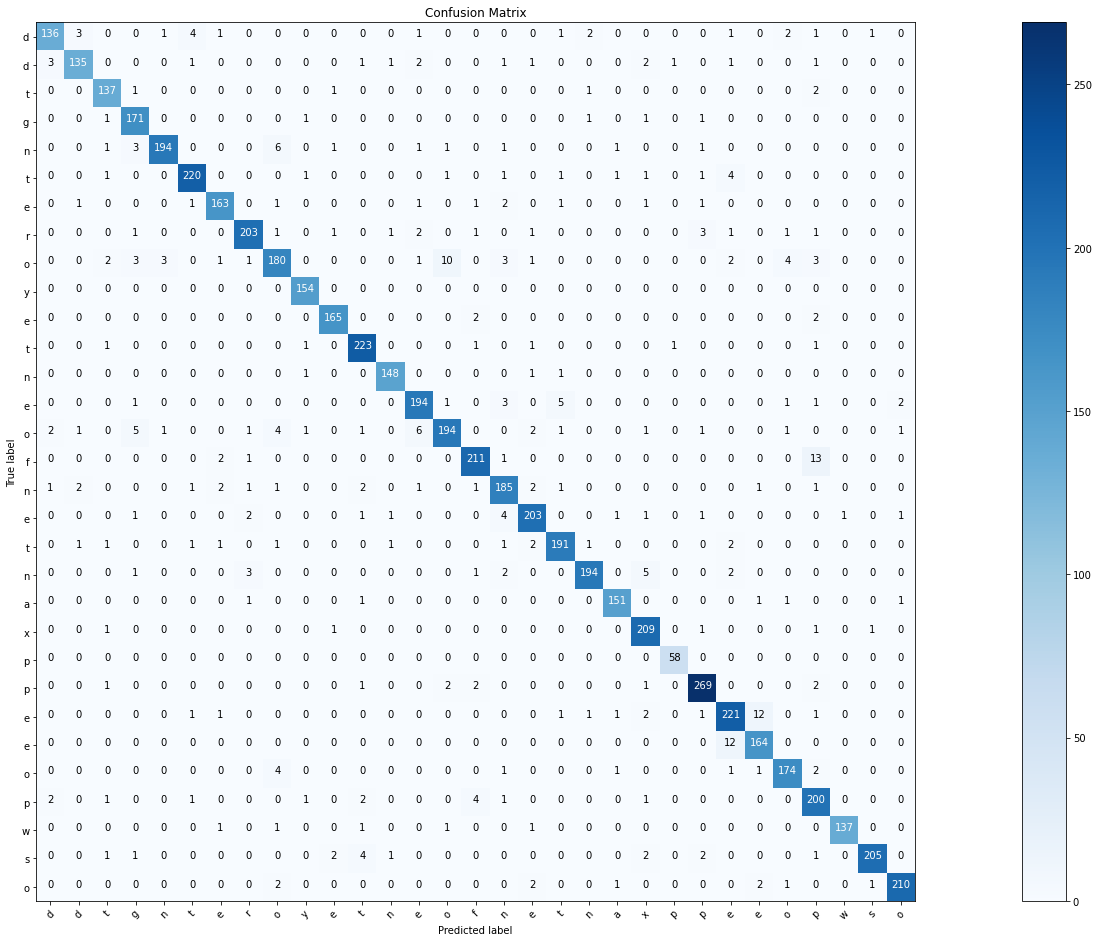

In [43]:
plt.figure(figsize=(30, 13))
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix');

In [ ]:
#SAVING THE CONFUSION MATRIX TO JSON FILE 

model_prediction = {"actual":y_test.tolist(),"predicted":rounded_preds.tolist(),"map":label_map}
with open('./confusion matrix/model_prediction_vs_actual.json','w+') as fp:
    json.dump(model_prediction,fp)

In [33]:
#CONVERING THE MODE TO TFLITE
import tensorflow as tf
tflite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tflite_converter.convert()
open("tf_lite_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmplgzu662s/assets


24273620